In [167]:
import os
import sys

sys.path.append(os.path.expanduser("~/mhw_stressviz/analysis/"))
from physiology import tpc, load

import xarray as xr
import numpy as np
import zarr

import s3fs
import gcsfs
import boto3

from importlib import reload
reload(tpc); reload(load)

import matplotlib
import matplotlib.pyplot as plt

import itertools
from functools import partial

from dask.distributed import Client

import cartopy.crs as ccrs
import cartopy.feature as cf

GCP_PROJECT_ID = '170771369993'
OISST_GCP = 'oisst/oisst.zarr'

%matplotlib inline

In [2]:
dask_client = Client()
dask_client

Client Scheduler: tcp://127.0.0.1:40699 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 8 Memory: 33.45 GB


# Verify generated MHWs + Properties

In [2]:
# Load SST
fs = gcsfs.GCSFileSystem(project=GCP_PROJECT_ID, token="../gc-pangeo.json")
oisst = xr.open_zarr(fs.get_mapper(OISST_GCP))
oisst = oisst.assign_coords(lon=(((oisst.lon + 180) % 360) - 180)).sortby('lon')

In [3]:
# Slice to PNW
PNW_LAT = slice(40, 50)
PNW_LON = slice(-145.9, -121.9)
oisst_pnw = oisst.sel(lat = PNW_LAT, lon = PNW_LON).persist()

In [4]:
# Load MHWs
awsfs = s3fs.S3FileSystem()
mhw_mapper = s3fs.S3Map("s3://mhw-stress/testregion", s3=awsfs)

In [5]:
mhws = xr.open_zarr(mhw_mapper)

In [6]:
mhws

<xarray.Dataset>
Dimensions:               (lat: 40, lon: 96, time: 13636)
Coordinates:
  * lat                   (lat) float32 40.125 40.375 40.625 ... 49.625 49.875
  * lon                   (lon) float32 -145.875 -145.625 ... -122.375 -122.125
  * time                  (time) datetime64[ns] 1981-09-01 ... 2018-12-31
Data variables:
    clim                  (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    duration              (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    index_end             (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    index_peak            (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    index_start           (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    intensity_cumulative  (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    intensity_max         (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    intensity_mean        (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    intensity_var         (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    mhw                   (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    rate_decline          (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>
    rate_onset            (lat, lon, time) float64 dask.array<chunksize=(5, 12, 3409), meta=np.ndarray>

## Make some Plots
We'll look at the 2014-2015 anomaly in the PNW

In [7]:
date_range = slice("2014-01-01", "2015-12-31")

In [8]:
mhw_pnw = mhws.sel(time=date_range)
sst_mhw_pnw = oisst_pnw.sel(time=date_range)

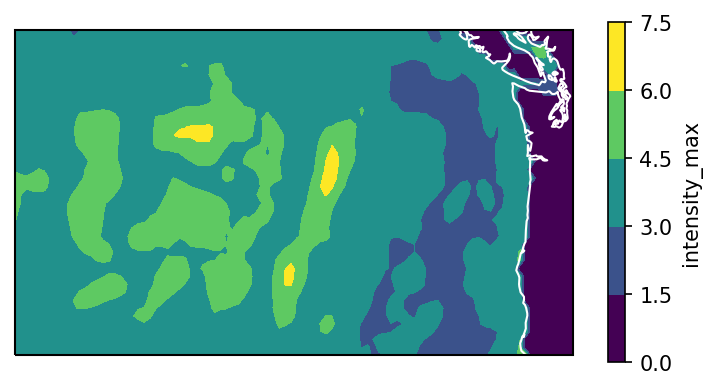

In [9]:
plt.figure(figsize=(6,3), dpi=150)
ax = plt.axes(projection=ccrs.Mercator.GOOGLE)
mhw_pnw.intensity_max.max(dim='time').plot.contourf(ax=ax, transform=ccrs.PlateCarree())
ax.add_feature(cf.NaturalEarthFeature('physical','coastline', '50m'), facecolor='none', edgecolor='white')


In [27]:
specific_loc = {'lat': 25, "lon": 25}


In [28]:
starts = np.unique(mhw_pnw.isel(**specific_loc).index_start.values)
ends = np.unique(mhw_pnw.isel(**specific_loc).index_end.values)
events = np.array(list(itertools.zip_longest(starts, ends, fillvalue=np.nan)))

In [67]:
sorted_events = np.diff(events, axis=1).argsort(axis=0)[::-1]

In [19]:
longest_event = events[np.diff(events, axis=1).argsort()[::-1][0]]

In [84]:
this_event = int(sorted_events[5].squeeze())

In [85]:
startdate = mhws.time[events[this_event][0].astype('int')]
enddate = mhws.time[events[this_event][1].astype('int')]

In [140]:
this_region = mhw_pnw.isel(**specific_loc)

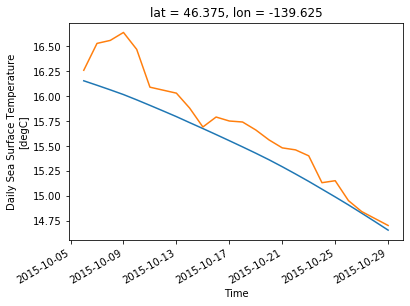

In [141]:
this_region.clim.sel(time=slice(startdate, enddate)).plot()
oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.plot()

## Appendix: bring in phyto

In [192]:
plankton = load.load_plankton("../data/Phytoplankton_temperature_growth_rate_dataset_2016_01_29/traits_derived_2016_01_29.csv")

In [193]:
plankton.genus.unique()

array(['Koliella', 'Klebsormidium', 'Phaeocystis', 'Pseudo-nitzschia',
       'Emiliania', 'Fibrocapsa', 'Gephyrocapsa', 'Calcidiscus',
       'Isochrysis', 'Trichodesmium', 'Pernambugia', 'Skeletonema',
       'Odontella', 'Chaetoceros', 'Rhizosolenia', 'Thalassionema',
       'Leonella', 'Gymnodinium', 'Crocosphaera', 'Helicotheca',
       'Karenia', 'Thalassiosira', 'Synechococcus', 'Amphiprora',
       'Leptocylindrus', 'Prochlorococcus', 'Chattonella', nan,
       'Akashiwo', 'Cochlodinium', 'Biceratium', 'Neoceratium',
       'Peridinium', 'Prorocentrum', 'Conticribra', 'Cylindrotheca',
       'Alexandrium', 'Micromonas', 'Diacronema', 'Pleurochrysis',
       'Proboscia', 'Chryosochromulina', 'Nannochloris'], dtype=object)

In [204]:
sk_plank = plankton.sample(1).iloc[0]

In [219]:
s = plankton.sample(1).iloc[0]
this_det = partial(tpc.perf_det, T_opt = s['mu.g.opt.list'], tpc = partial(tpc.tpc, a=s['mu.alist'], b=s['mu.blist'], z=s['mu.c.opt.list'], w=s['mu.wlist']))

In [220]:
this_det

functools.partial(<function perf_det at 0x7f5e9f12c950>, T_opt=12.60374739, tpc=functools.partial(<function tpc at 0x7f5e9e9bd7a0>, a=0.21800623, b=0.034377372999999996, z=11.34215425, w=17.31574077))

In [221]:
det_loc = this_det(oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.values)

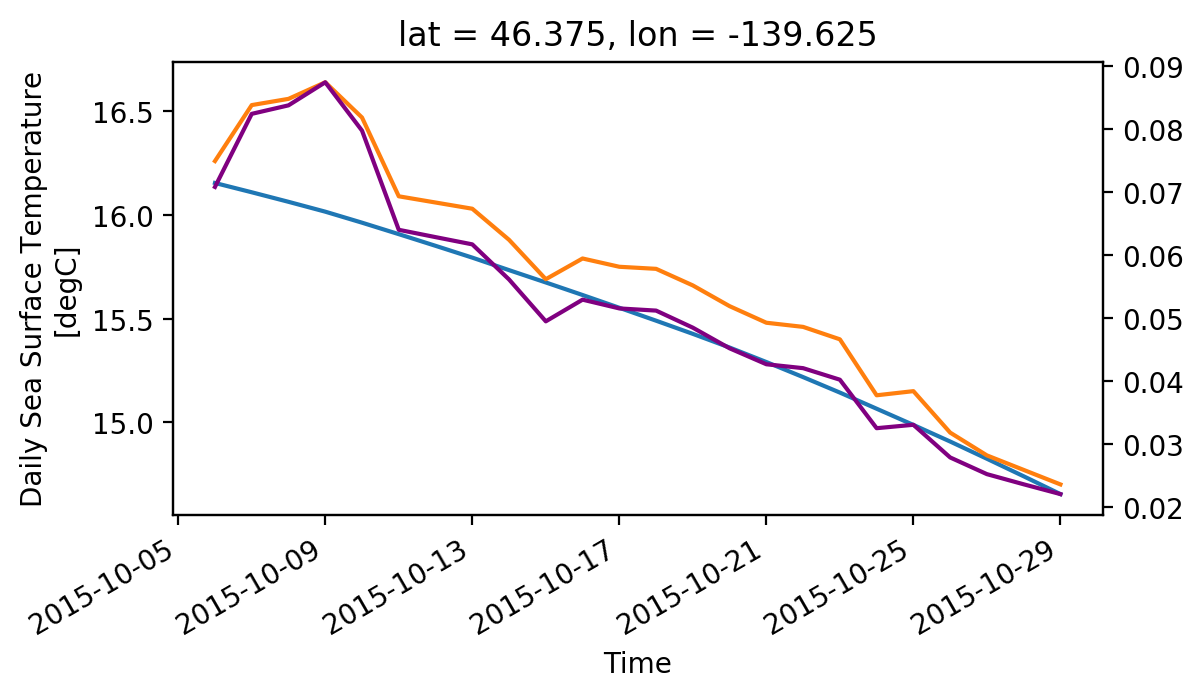

In [222]:
plt.figure(figsize=(6,3), dpi=200)
ax = plt.axes()
this_region.clim.sel(time=slice(startdate, enddate)).plot(ax=ax)

oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.plot(ax=ax)
ax1 = ax.twinx()

ax1.plot(oisst_pnw.sel(time = slice(startdate, enddate), lat=this_region.lat, lon=this_region.lon).sst.time, 
        det_loc, color='purple')

In [223]:
s

isolate.code                                                            1
source                               Terra Nova Bay, Ross Sea, Antarctica
isolation.latitude                                                 -74.83
isolation.longitude                                                 164.5
habitat                                                            marine
name                                  Koliella antarctica strain SAG 2030
speciesname                                           Koliella antarctica
former.name.1                                                         NaN
former.name.2                                                         NaN
strain                                                           SAG 2030
clone                                                                 NaN
species                                                        antarctica
genus                                                            Koliella
family                                